# 2 - Basic Learning on the IMDB Database
*By Marcus Schwarting and Andronicus Samsundar Rajasukumar*

In this notebook, we will:
- Introduce the framework of the IMDB database that we will be using
- Show how we use the Python package `psycopg2` to interact with the database and return desired cardinalities
- Demonstrate how random queries can be run locally to query the IMDB database
- Execute featurization of a large set of queries and run simple supervised learning routines

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import os
import gc
from sklearn.ensemble import RandomForestRegressor
import time
%matplotlib inline

We will need the minima and maxima on the dataset when forming random queries to ensure our predicates fall within an acceptable range.

In [2]:
max_min_df = pd.read_csv('imdb_max_min.csv')
max_min_df

,name,max,min,cardinality,num_unique_values
0,ci.id,63475835,1,63475835,63475835
1,ci.person_id,6226526,1,63475835,6220909
2,ci.movie_id,4730032,1,63475835,4238610
3,ci.person_role_id,4314864,1,29425052,4314865
4,ci.nr_order,1776839230,-2068070866,17480560,1667
5,ci.role_id,11,1,63475835,11
6,t.id,4736509,100000,4636509,4636509
7,t.kind_id,8,1,4636509,7
8,t.production_year,2115,1874,4346958,145
9,t.imdb_id,0,0,0,1


As described in Kipf et. al., we have the following breakdown from IMDB. We are especially interested in five tables from the IMDB that will be used. An attribute in bold will be used in join operations, an italicized attribute will be used in predicates.

|movie_companies (mc)||
|---|---|
|__*movie_id*__|
|*company_id*|
|*company_type_id*|

|title (t)||
|---|---|
|__*id*__|
|*kind_id*|
|*production_year*|

|cast_info (ci)||
|---|---|
|__*movie_id*__|
|*role_id*|

|movie_info (mi)||
|---|---|
|__*movie_id*__|
|*info_type_id*|

|movie_keyword (mk)||
|---|---|
|__*movie_id*__|
|*keyword_id*|

Based on these five tables, the block below will allow for the enumeration of a large set of join queries on the IMDB.

In [3]:
poss_tables = np.array(['movie_companies','title','cast_info','movie_keyword','movie_info'])
poss_tables_alias = np.array(['mc','t','ci','mk','mi'])
poss_joins = np.array(['t.id=mc.movie_id','t.id=ci.movie_id','t.id=mk.movie_id','t.id=mi.movie_id'])
poss_preds_cols = np.array(['mc.company_id','mc.company_type_id','t.kind_id','t.production_year',\
                   'ci.role_id','mi.info_type_id','mk.keyword_id','mi.info_type_id'])
poss_preds_ops = np.array(['<','>','='])

Connect to the local IMDB server using `psycopg2`

In [4]:
connection = psycopg2.connect(database='imdb',user='meschw04',\
                              password='password',host='127.0.0.1',port='5432')
cur = connection.cursor()

Test on a practice query, obtain the resulting cardinality. This query is pulled from the JOB-light benchmark.

In [5]:
test_q = 'SELECT COUNT(*) FROM movie_companies mc,title t,movie_keyword mk WHERE '+\
                    't.id=mc.movie_id AND t.id=mk.movie_id AND mk.keyword_id=117;'
cur.execute(test_q)
cols = cur.fetchall()
card = int(cols[0][0])
print(test_q)
print(f'Test Query Cardinality: {card}')

SELECT COUNT(*) FROM movie_companies mc,title t,movie_keyword mk WHERE t.id=mc.movie_id AND t.id=mk.movie_id AND mk.keyword_id=117;
Test Query Cardinality: 13412


By stitching together tables, joins, and predicates, we are now in a position to generate random queries and determine their cardinality.

In [6]:
def gen_rand_queries(n_queries):
    all_queries_li = []
    for j in range(n_queries):
        #RANDOM GENERATION OF QUERIES
        num_joins = np.random.choice(range(1,4),1)[0]
        num_preds = np.random.choice(range(1,5),1)[0]
        selected_joins = np.random.choice(poss_joins,num_joins,replace=False)
        selected_tables = []
        for i in selected_joins:
            tb1 = i.split('=')[0]
            tb2 = i.split('=')[1]
            tb1 = tb1[:tb1.index('.')]
            tb2 = tb2[:tb2.index('.')]
            selected_tables+=[tb1,tb2]
        selected_tables = list(set(selected_tables))
        selected_preds = [i for i in poss_preds_cols if i.split('.')[0] in selected_tables]
        selected_preds = np.random.choice(selected_preds,min(num_preds,len(selected_preds)),replace=False)

        rand_query = f'SELECT COUNT(*) FROM '
        rand_query+=', '.join([f'{poss_tables[poss_tables_alias.tolist().index(i)]} {i}' for i in selected_tables])
        rand_query+=' WHERE '
        rand_query+=' AND '.join(selected_joins)+' AND '
        pred_strs = []
        for pred in selected_preds:
            pred_max_min = max_min_df.loc[max_min_df['name']==pred]
            pred_operation = np.random.choice(['<','>','='])
            pred_value = np.random.choice(range(int(pred_max_min['min']),\
                                                int(pred_max_min['max'])+1),1)[0]
            pred_strs.append(f'{pred} {pred_operation} {pred_value}')
        rand_query+=' AND '.join(pred_strs)+';'
        all_queries_li.append(rand_query)
    return all_queries_li

In [7]:
ex_gen_query = gen_rand_queries(1)
print(ex_gen_query[0])

SELECT COUNT(*) FROM movie_info mi, title t, movie_keyword mk, movie_companies mc WHERE t.id=mi.movie_id AND t.id=mc.movie_id AND t.id=mk.movie_id AND mk.keyword_id = 61156 AND mc.company_id = 37861 AND mi.info_type_id = 38 AND t.kind_id < 4;


The block of code below will generate 5000 random queries on the IMDB, run each query, and iteratively write both the original query and the resulting cardinality. __Only run this if you are ready to lock up your computer for a great deal of time.__

In [8]:
###Generate 5000 queries with cardinalities on the IMDB.
###WARNING: Do not run unless you really want to query the DB for a long time!

#gen_queries = gen_rand_queries(5000)
#for q in gen_queries:
#    cur.execute(q)
#    cols = cur.fetchall()
#    print(q,cols[0][0])
#    open('imdb_rand_queries.sql','a').write(f'{q}{cols[0][0]}\n')
#    gc.collect()

Once all queries have been generated, we read in the resulting file and featurize all queries based on the breakdown of the query tables, join operations, and predicate operations.

In [9]:
def featurize_sql_query(query):
    #COVER TABLES
    tables_embedding = np.zeros(len(poss_tables))
    for i in range(len(poss_tables)):
        if poss_tables[i] in query:
            tables_embedding[i]=1
    if np.sum(tables_embedding)==0:
        raise Exception(f'No tables selected: {query}')
    #COVER JOINS
    joins_embedding = np.zeros(len(poss_joins))
    all_poss_joins = poss_joins.copy().tolist()
    for i in poss_joins:
        sub=i.split('=')
        all_poss_joins.append(f'{sub[1]}={sub[0]}')
    for i in range(len(poss_joins)):
        if all_poss_joins[i] in query:
            joins_embedding[i%3]=1
    #COVER PREDICATES
    predicates_embedding = np.zeros(len(poss_preds_cols)*3)
    preds_search = query.split(' AND ')
    for i in range(len(poss_preds_cols)):
        for j in preds_search:
            if poss_preds_cols[i] in j: #WE HAVE A HIT!
                hit = j.replace(';','')
                pred_max_min = max_min_df.loc[max_min_df['name']==poss_preds_cols[i]]
                idx_place = 3*i
                if '<' in hit:
                    val = int(hit.split('<')[1])
                elif '>' in hit:
                    idx_place+=1
                    val = int(hit.split('>')[1])
                else:
                    idx_place+=2
                    val = int(hit.split('=')[1])
                norm_val = float(val)-float(pred_max_min['min'])
                norm_val /= (int(pred_max_min['max'])-int(pred_max_min['min']))
                predicates_embedding[idx_place]=norm_val
    return tables_embedding,joins_embedding,predicates_embedding

In [13]:
def featurize_from_file(filename):
    dataset = open(filename,'r').read().split('\n')
    queries_li = []
    verbose_li = []
    cardinalities_li = []
    q_tables_li = []
    q_joins_li = []
    q_preds_li = []
    for i in dataset:
        try:
            q = i.split(';')[0]+';'
            verbose_li.append(q)
            t_e, j_e, p_e = featurize_sql_query(q)
            queries_li.append(t_e.tolist()+j_e.tolist()+p_e.tolist())
            cardinalities_li.append(int(i.split(';')[1]))
            q_tables_li.append(t_e)
            q_joins_li.append(j_e)
            q_preds_li.append(p_e)
        except Exception as e:
            print(e)
            pass
    queries_li = np.array(queries_li)
    cardinalities_li = np.array(cardinalities_li)
    sep_li = [q_tables_li,q_joins_li,q_preds_li]
    return queries_li,cardinalities_li,verbose_li,sep_li

We have aggregated a large set of queries within `all_train_queries.sql`, and can now read these from disk. Similarly, we have our benchmark set of queries, `job_light.sql`, which we can similarly read from disk and use to benchmark our overall performance for any model.

In [14]:
train_queries, train_cards, train_verb,train_sep = featurize_from_file('all_train_queries.sql')

In [19]:
test_queries, test_cards, test_verb, test_sep = featurize_from_file('job_light.sql')

After normalizing over test and training queries, we are ready to train a simple supervised learning algorithm (RFR).

In [20]:
max_train_card = max(train_cards)
X = train_queries.copy()
y = train_cards.copy()/max_train_card

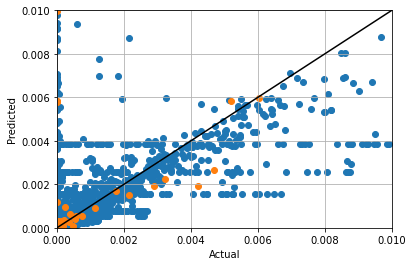

In [27]:
rfr = RandomForestRegressor().fit(X,y)
rfr_out_y = rfr.predict(X)
rfr_out_job = rfr.predict(test_queries)*max_train_card
plt.figure()
plt.scatter(y,rfr_out_y)
plt.scatter(test_cards/max_train_card,rfr_out_job/max_train_card)
plt.xlim([0,0.01])
plt.ylim([0,0.01])
plt.plot([0,1],[0,1],color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid()
plt.show()

In [38]:
print(f'Average Cardinality Est. Error: {round(np.average(abs((rfr_out_job-test_cards)/max_train_card))*100,4)}%')

Average Cardinality Est. Error: 0.2184%


Considering the smaller training set, the accuracy of this model compared to the MSCN from Kipf et. al. is actually nearing a competitive score. This inspires greater confidence that a similarly constructed model may attain greater accuracy in a shorter training time than the currently reported state of the art.